Practiced file

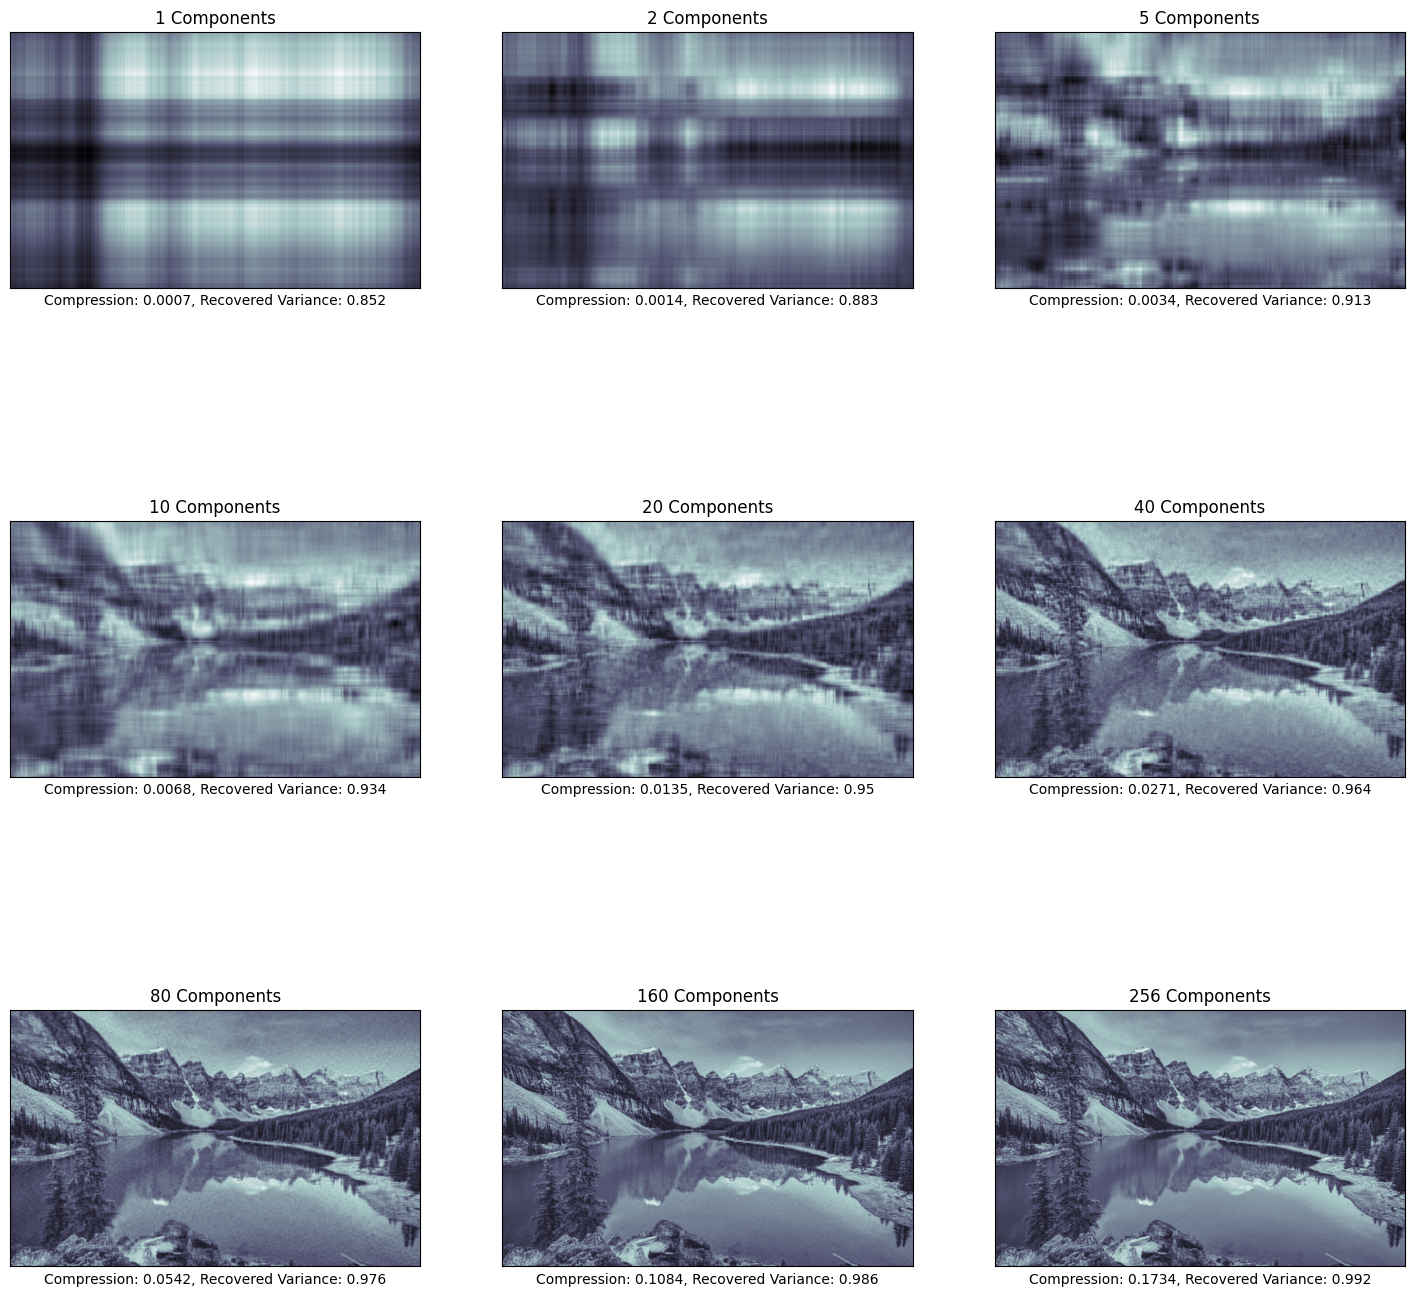

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class ImgCompression(object):
    def __init__(self):
        pass

    def svd(self, X):
        if len(X.shape) == 2:
            U, S, V = np.linalg.svd(X)
        else:
            N, D = X.shape[0], X.shape[1]
            min_ND = min(N, D)

            U0, S0, V0 = np.linalg.svd(X[:, :, 0])
            S0 = S0.reshape((min_ND, 1))

            U1, S1, V1 = np.linalg.svd(X[:, :, 1])
            S1 = S1.reshape((min_ND, 1))

            U2, S2, V2 = np.linalg.svd(X[:, :, 2])
            S2 = S2.reshape((min_ND, 1))

            U = np.array([U0, U1, U2])
            U = U.transpose(1, 2, 0)

            S = np.concatenate((S0, S1, S2), axis=1)

            V = np.array([V0, V1, V2])
            V = V.transpose(1, 2, 0)

        return U, S, V

    def rebuild_svd(self, U, S, V, k):
        if len(U.shape) == 2:
            t1 = np.matmul(U[:, :k], np.diag(S)[:k, :k])
            Xrebuild = np.matmul(t1, V[:k, :])
        else:
            N = U.shape[0]
            D = V.shape[0]

            U0 = U[:, :, 0]
            S0 = S[:, 0]
            V0 = V[:, :, 0]
            t1 = np.matmul(U0[:, :k], np.diag(S0)[:k, :k])
            Xrebuild0 = np.matmul(t1, V0[:k, :])

            U1 = U[:, :, 1]
            S1 = S[:, 1]
            V1 = V[:, :, 1]
            t1 = np.matmul(U1[:, :k], np.diag(S1)[:k, :k])
            Xrebuild1 = np.matmul(t1, V1[:k, :])

            U2 = U[:, :, 2]
            S2 = S[:, 2]
            V2 = V[:, :, 2]
            t1 = np.matmul(U2[:, :k], np.diag(S2)[:k, :k])
            Xrebuild2 = np.matmul(t1, V2[:k, :])

            Xrebuild = np.array([Xrebuild0, Xrebuild1, Xrebuild2])
            Xrebuild = Xrebuild.transpose(1, 2, 0)

        return Xrebuild

    def compression_ratio(self, X, k):
        if len(X.shape) == 2:
            num_orig = X.shape[0] * X.shape[1]
            num_compress = k * (1 + X.shape[0] + X.shape[1])
        else:
            num_orig = X.shape[0] * X.shape[1] * X.shape[2]
            num_compress = k * (1 + X.shape[0] + X.shape[1]) * X.shape[2]

        compression_ratio = num_compress * 1.0 / num_orig
        return compression_ratio

    def recovered_variance_proportion(self, S, k):
        S2 = S ** 2
        if len(S.shape) == 1:
            recovered_var = np.sum(S2[:k]) / np.sum(S2)
        else:
            recovered_var0 = np.sum(S2[:k, 0]) / np.sum(S2[:, 0])
            recovered_var1 = np.sum(S2[:k, 1]) / np.sum(S2[:, 1])
            recovered_var2 = np.sum(S2[:k, 2]) / np.sum(S2[:, 2])
            recovered_var = [recovered_var0, recovered_var1, recovered_var2]

        return recovered_var

image = plt.imread("/home/gpaudel/Pictures/nature.jpg") / 255.

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

bw_image = rgb2gray(image)

imcompression = ImgCompression()
U, S, V = imcompression.svd(bw_image)

component_num = [1, 2, 5, 10, 20, 40, 80, 160, 256]

fig = plt.figure(figsize=(18, 18))

i = 0
for k in component_num:
    img_rebuild = imcompression.rebuild_svd(U, S, V, k)
    c = np.around(imcompression.compression_ratio(bw_image, k), 4)
    r = np.around(imcompression.recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild, cmap=plt.cm.bone)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {c}, Recovered Variance: {r}")
    i += 1

plt.show()


First, it checks the shape of the input matrix X. If the shape has two dimensions, it means that X is a grayscale image, and the regular SVD can be directly applied to it.

If the shape of X has more than two dimensions, it means that X is an RGB image. In this case, the method performs SVD separately on each color channel (red, green, and blue) of the image.

For each color channel, the method applies the np.linalg.svd function to obtain the singular value decomposition. Let's take the example of the red channel (X[:, :, 0]) to understand the process:

a. It applies np.linalg.svd(X[:, :, 0]) to compute the singular value decomposition of the red channel of the image. The returned values are U0, S0, and V0.

b. It reshapes S0 to have dimensions (min_ND, 1), where min_ND is the minimum of the number of rows and columns in the red channel.

After obtaining the singular value decompositions for all three color channels, the method combines the results to form the final U, S, and V matrices.

a. It creates an array U containing the U0, U1, and U2 matrices for the red, green, and blue channels, respectively. The dimensions of U are (N, D, 3), where N is the number of rows, D is the number of columns, and 3 represents the three color channels.

b. It transposes U to have the dimensions (D, N, 3).

c. It concatenates the reshaped singular value matrices S0, S1, and S2 along the second axis to form the S matrix. The dimensions of S are (min_ND, 3).

d. It creates an array V containing the V0, V1, and V2 matrices for the red, green, and blue channels, respectively. The dimensions of V are (D, D, 3).

e. It transposes V to have the dimensions (D, D, 3).

Finally, the method returns the U, S, and V matrices.

The rebuild_svd method takes the decomposed matrices U, S, and V from the SVD and a parameter k that represents the number of singular values to retain. It reconstructs the original matrix or image using these decomposed matrices. Let's go through the code step by step:

First, it checks the shape of the U matrix. If it has two dimensions, it means that the original matrix is grayscale.

If the U matrix has more than two dimensions, it means that the original matrix is an RGB image. In this case, the method rebuilds each color channel separately.

For grayscale or each color channel of an RGB image, the method performs the following steps:

a. It selects the corresponding components U, S, and V for the specific color channel. For example, for the red channel, it assigns U0, S0, and V0 to the components of U, S, and V respectively.

b. It performs matrix multiplication to reconstruct the matrix or image. It first computes t1 by multiplying the left singular vectors U with the diagonal matrix of singular values S, considering only the first k singular values. This is achieved by slicing U[:, :k] and np.diag(S0)[:k, :k].

c. It then multiplies t1 with the right singular vectors V by slicing V0[:k, :].

d. The result of the multiplication is stored in Xrebuild0 for the red channel. Similarly, Xrebuild1 and Xrebuild2 are computed for the green and blue channels.

If the original matrix is an RGB image, the method combines the reconstructed channels to form the final reconstructed image:

a. It creates an array Xrebuild containing Xrebuild0, Xrebuild1, and Xrebuild2 for the red, green, and blue channels, respectively.

b. It transposes Xrebuild to have the dimensions (N, D, 3).

Finally, the method returns the reconstructed matrix or image Xrebuild

The compression_ratio method calculates the compression ratio achieved by the image compression algorithm based on the number of retained singular values k. Let's break down the code:

First, it checks the shape of the input matrix X. If the shape has two dimensions, it means that the original matrix is grayscale. If it has three dimensions, it means that the original matrix is an RGB image.

If the matrix is grayscale, it computes the number of elements in the original matrix by multiplying the number of rows X.shape[0] with the number of columns X.shape[1]. It stores this value in the variable num_orig.

It computes the number of elements in the compressed matrix by multiplying k with the sum of 1 and the number of rows and columns of the original matrix. This represents the number of elements needed to store the compressed matrix. It stores this value in the variable num_compress.

If the matrix is an RGB image, it extends the calculation to include the number of color channels X.shape[2] in both num_orig and num_compress.

The compression ratio is then calculated by dividing num_compress by num_orig and storing the result in the variable compression_ratio.

Finally, the compression ratio is returned.

The recovered_variance_proportion method calculates the proportion of recovered variance based on the retained singular values S and the number of singular values k. Let's go through the code:

The method first calculates the square of each singular value by performing element-wise exponentiation: S2 = S ** 2.

It then checks the shape of the S array to determine if it is a 1D array (grayscale) or a 2D array (RGB image). If the shape has one dimension, it means that the original matrix is grayscale. If it has two dimensions, it means that the original matrix is an RGB image.

If the matrix is grayscale (1D array), it computes the sum of the squared singular values up to the k-th index using slicing: np.sum(S2[:k]). This represents the sum of the variance retained by the k singular values. It divides this sum by the total sum of all squared singular values: np.sum(S2) to get the proportion of recovered variance. The result is stored in the variable recovered_var.

If the matrix is an RGB image (2D array), it extends the calculation to each color channel. It computes the sum of squared singular values up to the k-th index for each channel separately and divides it by the total sum of squared singular values for that channel. The proportion of recovered variance for each channel is stored in the variables recovered_var0, recovered_var1, and recovered_var2 for the red, green, and blue channels, respectively. These values are then stored in a list [recovered_var0, recovered_var1, recovered_var2] and assigned to the variable recovered_var.

Finally, the recovered_var variable, containing the proportion of recovered variance, is returned.

The provided code performs image compression using singular value decomposition (SVD) and visualizes the reconstructed images with different numbers of components. Let's go through the code step by step:

The code loads an image named "image_2.jpg" using plt.imread() function and divides it by 255 to normalize the pixel values between 0 and 1.

The rgb2gray() function is defined to convert the RGB image to grayscale using the formula gray = 0.299 * red + 0.587 * green + 0.114 * blue. It uses numpy's dot product to perform the multiplication.

The bw_image variable stores the grayscale version of the loaded image by calling the rgb2gray() function.

An instance of the ImgCompression class is created with imcompression = ImgCompression().

The SVD is performed on the grayscale image by calling the svd() method of the ImgCompression object. The resulting singular vectors and singular values are assigned to U, S, and V, respectively.

The component_num list contains the number of components (singular values) to be used for reconstruction. It specifies different values: [1, 2, 5, 10, 20, 40, 80, 160, 256].

A figure is created with a size of 18x18 using fig = plt.figure(figsize=(18, 18)).

A loop iterates over each value of k in component_num.

Inside the loop, the reconstruction of the image is performed by calling the rebuild_svd() method of the ImgCompression object with the given singular vectors U, singular values S, and singular vectors V, along with the current value of k. The reconstructed image is assigned to img_rebuild.

The compression ratio and recovered variance proportion are computed by calling the compression_ratio() and recovered_variance_proportion() methods of the ImgCompression object, respectively, using the grayscale image bw_image and the current value of k. The results are assigned to variables c and r.

An axis is added to the figure using ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[]), which creates a subplot in a 3x3 grid of subplots.

The reconstructed image is displayed on the axis using ax.imshow(img_rebuild, cmap=plt.cm.bone).

The title of the subplot is set to indicate the number of components used (k).

The xlabel of the subplot is set to display the compression ratio (c) and recovered variance proportion (r).

The loop continues with the next value of k.

Finally, plt.show() is called to display the figure with all the reconstructed images.

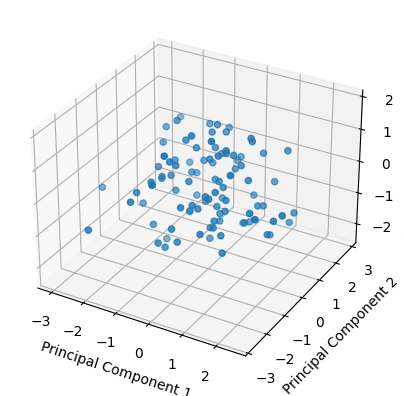

In [1]:
import matplotlib.pyplot as plt
import numpy as np

class image_compression:
    def __init__(self, image):
        self.image = image
        self.rgb_image = None
        self.gray_image = None
        self.U = None
        self.sigma = None
        self.V = None

    def load_image(self):
        self.rgb_image = plt.imread(self.image)

    def cvt_to_grayscale(self):
        self.gray_image = np.dot(self.rgb_image[..., :3], [0.2989, 0.5870, 0.1140])

    def svd(self):
        A = self.gray_image
        covariance_mat = A.T @ A
        eigenvalues, eigenvectors = np.linalg.eig(covariance_mat)
        sort_index_desc = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_index_desc]
        eigenvectors = eigenvectors[:, sort_index_desc]
        sigma = np.sqrt(eigenvalues)
        sigma_value = 1 / sigma
        sigma_matrix = np.diag(sigma_value)
        U = A @ eigenvectors @ sigma_matrix
        V = eigenvectors
        self.U = U
        self.sigma = sigma
        self.V = V

    def compress_image(self, rank):
        U = self.U[:, :rank]
        sigma = np.diag(self.sigma[:rank])
        V = self.V[:, :rank]
        compressed_image = U @ sigma @ V.T
        return compressed_image.astype(np.float64)

    def compression_ratio(self, rank):
        original_size = self.gray_image.size
        compressed_size = rank * (self.U.shape[0] + self.V.shape[1] + 1) 
        ratio = compressed_size / original_size
        return ratio

    def display(self, ranks):
        for r in ranks:
            compression_ratio = self.compression_ratio(r)
            print("Compression ratio at rank", r, "is:", compression_ratio)

image = '/home/gpaudel/Pictures/nature.jpg'
ranks = [5, 10, 50, 100]

result = image_compression(image)
result.load_image()
result.cvt_to_grayscale()
result.svd()
result.display(ranks)


Compression ratio at rank 5 is: 0.003385959201388889
Compression ratio at rank 10 is: 0.006771918402777778
Compression ratio at rank 50 is: 0.03385959201388889
Compression ratio at rank 100 is: 0.06771918402777778


/tmp/ipykernel_5911/160382806.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return compressed_image.astype(np.float64)


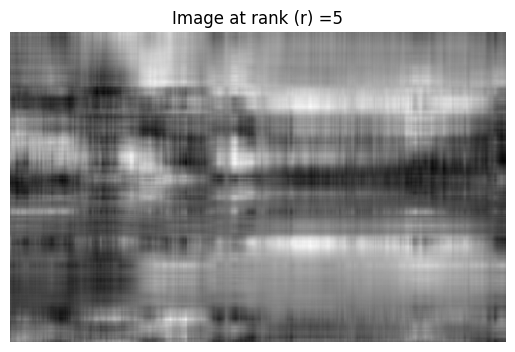

compression ratio at rank 5 is: 0.003385959201388889
image size at rank 5 is: 31205.000000000004


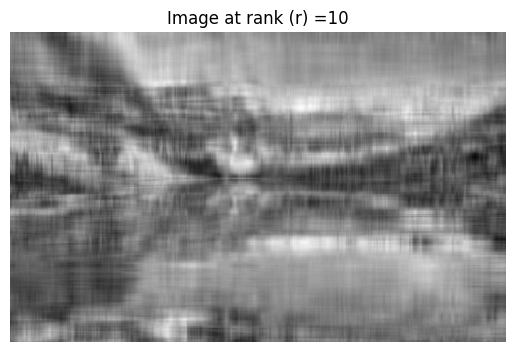

compression ratio at rank 10 is: 0.006771918402777778
image size at rank 10 is: 62410.00000000001


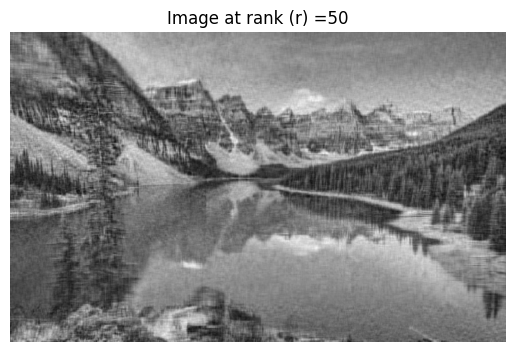

compression ratio at rank 50 is: 0.03385959201388889
image size at rank 50 is: 312050.0


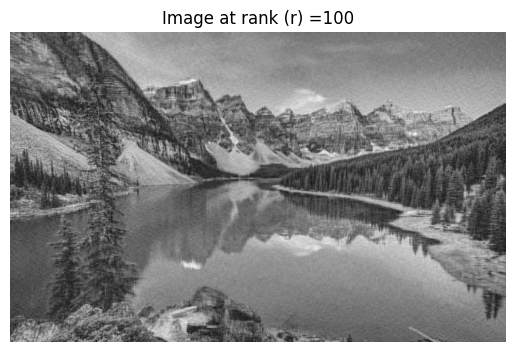

compression ratio at rank 100 is: 0.06771918402777778
image size at rank 100 is: 624100.0
